In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Total Fake Files: 5104
Total Real Files: 5104

Analyzing Fake Audio:
File: /content/drive/My Drive/Projects/fake_or_real_dataset/fake/recording5671.wav_norm_mono.wav
Sample Rate: 16000 Hz
Duration: 2.02 seconds
Shape: (32246,)


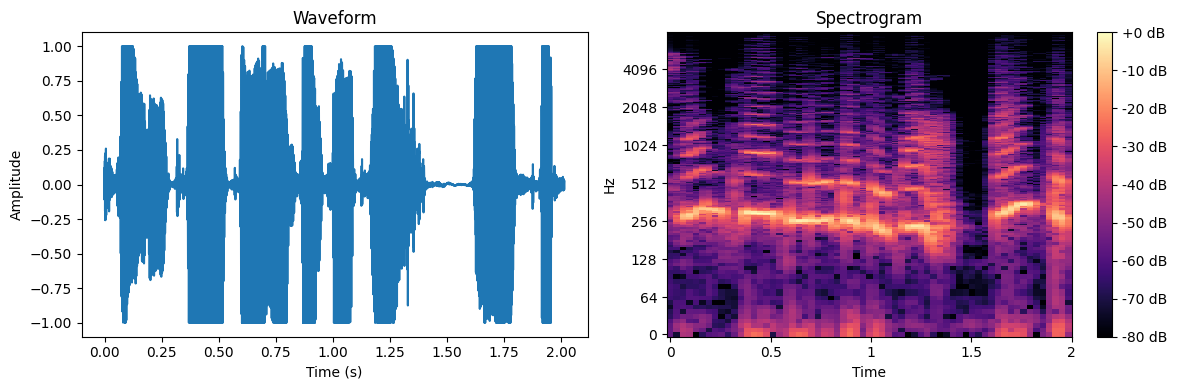


Analyzing Real Audio:
File: /content/drive/My Drive/Projects/fake_or_real_dataset/real/recording8677.wav_norm_mono.wav
Sample Rate: 16000 Hz
Duration: 2.34 seconds
Shape: (37487,)


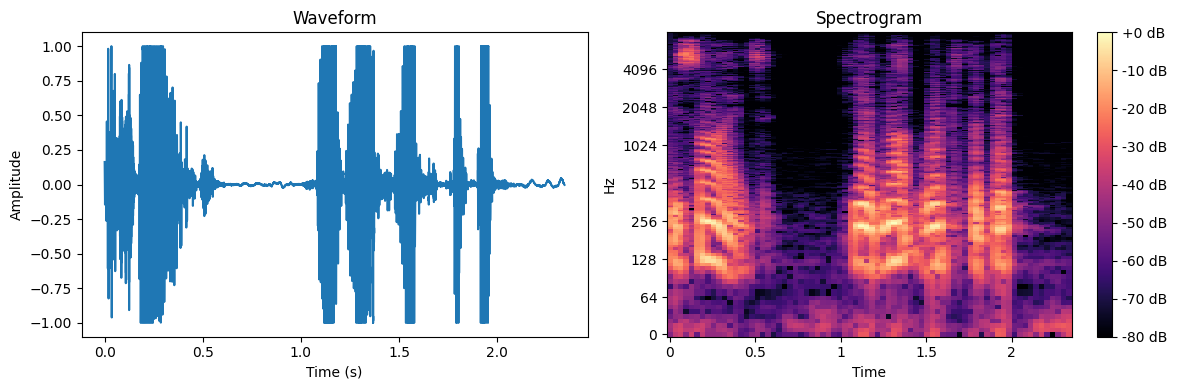

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


dataset_path = "/content/drive/My Drive/Projects/fake_or_real_dataset/"

fake_path = os.path.join(dataset_path, "fake")
real_path = os.path.join(dataset_path, "real")

# Function to load and analyze an audio file
def analyze_audio(file_path):
    # Load audio
    audio, sr = librosa.load(file_path, sr=None)  # sr=None to keep original sample rate
    duration = librosa.get_duration(y=audio, sr=sr)

    print(f"File: {file_path}")
    print(f"Sample Rate: {sr} Hz")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Shape: {audio.shape}")

    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Waveform")
    plt.plot(np.linspace(0, duration, len(audio)), audio)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()

    return audio, sr

# Load one fake and one real audio file
fake_files = [f for f in os.listdir(fake_path) if f.endswith('.wav')]
real_files = [f for f in os.listdir(real_path) if f.endswith('.wav')]

print(f"Total Fake Files: {len(fake_files)}")
print(f"Total Real Files: {len(real_files)}")

# Analyze one file from each class
if fake_files:
    fake_file = os.path.join(fake_path, fake_files[0])
    print("\nAnalyzing Fake Audio:")
    fake_audio, fake_sr = analyze_audio(fake_file)

if real_files:
    real_file = os.path.join(real_path, real_files[0])
    print("\nAnalyzing Real Audio:")
    real_audio, real_sr = analyze_audio(real_file)

In [ ]:
import librosa

# Check sample rates for a few files
def check_sample_rates(directory, num_files=5):
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    for i, file in enumerate(files[:num_files]):
        file_path = os.path.join(directory, file)
        audio, sr = librosa.load(file_path, sr=None)
        print(f"File {i+1}: {file}, Sample Rate: {sr} Hz")

print("Checking fake audio sample rates...")
check_sample_rates(fake_path)
print("\nChecking real audio sample rates...")
check_sample_rates(real_path)

Checking fake audio sample rates...
File 1: recording5671.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 2: recording5670.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 3: recording565.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 4: recording5663.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 5: recording5675.wav_norm_mono.wav, Sample Rate: 16000 Hz

Checking real audio sample rates...
File 1: recording8677.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 2: recording8676.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 3: recording8694.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 4: recording8698.wav_norm_mono.wav, Sample Rate: 16000 Hz
File 5: recording8699.wav_norm_mono.wav, Sample Rate: 16000 Hz


In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

# Paths
dataset_path = "/content/drive/My Drive/Projects/fake_or_real_dataset/"
fake_path = os.path.join(dataset_path, "fake")
real_path = os.path.join(dataset_path, "real")
output_path = "/content/drive/My Drive/Projects/audio_features/"  # Where to save features
os.makedirs(output_path, exist_ok=True)

# Parameters
sample_rate = 16000  # Target sample rate
n_mfcc = 13          # Number of MFCC coefficients
n_frames = 100       # Target number of time frames (pad/truncate to this)

# Function to extract MFCCs from an audio file
def extract_mfcc(file_path, sr=sample_rate, n_mfcc=n_mfcc, n_frames=n_frames):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=sr)
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate to fixed length
        if mfccs.shape[1] > n_frames:
            mfccs = mfccs[:, :n_frames]
        else:
            pad_width = n_frames - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
        return mfccs  # Shape: (n_mfcc, n_frames)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Collect all file paths and labels
fake_files = []
real_files = []

# Recursive file collection
for root, dirs, files in os.walk(fake_path):
    fake_files.extend([os.path.join(root, f) for f in files if f.endswith('.wav')])
for root, dirs, files in os.walk(real_path):
    real_files.extend([os.path.join(root, f) for f in files if f.endswith('.wav')])

print(f"Total Fake Files: {len(fake_files)}")
print(f"Total Real Files: {len(real_files)}")

# Extract MFCCs and labels
features = []
labels = []  # 0 for fake, 1 for real

# Process fake files
print("Processing fake audio...")
for i, file_path in enumerate(fake_files):
    if i % 500 == 0:
        print(f"Processed {i}/{len(fake_files)} fake files")
    mfcc = extract_mfcc(file_path)
    if mfcc is not None:
        features.append(mfcc)
        labels.append(0)

# Process real files
print("Processing real audio...")
for i, file_path in enumerate(real_files):
    if i % 500 == 0:
        print(f"Processed {i}/{len(real_files)} real files")
    mfcc = extract_mfcc(file_path)
    if mfcc is not None:
        features.append(mfcc)
        labels.append(1)

# Convert to NumPy arrays
features = np.array(features)  # Shape: (num_samples, n_mfcc, n_frames)
labels = np.array(labels)      # Shape: (num_samples,)

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Save to disk
np.save(os.path.join(output_path, "X_train.npy"), X_train)
np.save(os.path.join(output_path, "X_test.npy"), X_test)
np.save(os.path.join(output_path, "y_train.npy"), y_train)
np.save(os.path.join(output_path, "y_test.npy"), y_test)

print("Features and labels saved to disk!")

Total Fake Files: 5104
Total Real Files: 5104
Processing fake audio...
Processed 0/5104 fake files
Processed 500/5104 fake files
Processed 1000/5104 fake files
Processed 1500/5104 fake files
Processed 2000/5104 fake files
Processed 2500/5104 fake files
Processed 3000/5104 fake files
Processed 3500/5104 fake files
Processed 4000/5104 fake files
Processed 4500/5104 fake files
Processed 5000/5104 fake files
Processing real audio...
Processed 0/5104 real files
Processed 500/5104 real files
Processed 1000/5104 real files
Processed 1500/5104 real files
Processed 2000/5104 real files
Processed 2500/5104 real files
Processed 3000/5104 real files
Processed 3500/5104 real files
Processed 4000/5104 real files
Processed 4500/5104 real files
Processed 5000/5104 real files
Features shape: (10208, 13, 100)
Labels shape: (10208,)
Features and labels saved to disk!


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

# Paths
output_path = "/content/drive/My Drive/Projects/audio_features/"
model_path = "/content/drive/My Drive/Projects/audio_forensics_model.pth"

# Load the saved features
X_train = np.load(os.path.join(output_path, "X_train.npy"))
X_test = np.load(os.path.join(output_path, "X_test.npy"))
y_train = np.load(os.path.join(output_path, "y_train.npy"))
y_test = np.load(os.path.join(output_path, "y_test.npy"))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension: (N, 1, 13, 100)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Input: (1, 13, 100), Output: (16, 13, 100)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output: (32, 13, 100)
        self.pool = nn.MaxPool2d(2, 2)  # Output: (32, 6, 50)
        self.fc1 = nn.Linear(32 * 6 * 50, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: fake (0), real (1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = AudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Validation accuracy
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Training Accuracy: {100 * correct / total:.2f}%")

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Save the model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

X_train shape: (8166, 13, 100)
X_test shape: (2042, 13, 100)
y_train shape: (8166,)
y_test shape: (2042,)
Using device: cuda
Epoch 1/20, Loss: 0.8225
Training Accuracy: 87.90%
Epoch 2/20, Loss: 0.2893
Training Accuracy: 93.33%
Epoch 3/20, Loss: 0.2254
Training Accuracy: 95.31%
Epoch 4/20, Loss: 0.1757
Training Accuracy: 96.11%
Epoch 5/20, Loss: 0.1586
Training Accuracy: 96.91%
Epoch 6/20, Loss: 0.1446
Training Accuracy: 98.25%
Epoch 7/20, Loss: 0.1150
Training Accuracy: 97.98%
Epoch 8/20, Loss: 0.1076
Training Accuracy: 98.57%
Epoch 9/20, Loss: 0.0868
Training Accuracy: 98.60%
Epoch 10/20, Loss: 0.0832
Training Accuracy: 98.87%
Epoch 11/20, Loss: 0.0704
Training Accuracy: 98.05%
Epoch 12/20, Loss: 0.0829
Training Accuracy: 99.35%
Epoch 13/20, Loss: 0.0607
Training Accuracy: 99.57%
Epoch 14/20, Loss: 0.0566
Training Accuracy: 99.51%
Epoch 15/20, Loss: 0.0473
Training Accuracy: 99.56%
Epoch 16/20, Loss: 0.0784
Training Accuracy: 99.29%
Epoch 17/20, Loss: 0.0570
Training Accuracy: 99.73%


Generating confidence map for: /content/drive/My Drive/Projects/fake_or_real_dataset/real/recording8677.wav_norm_mono.wav


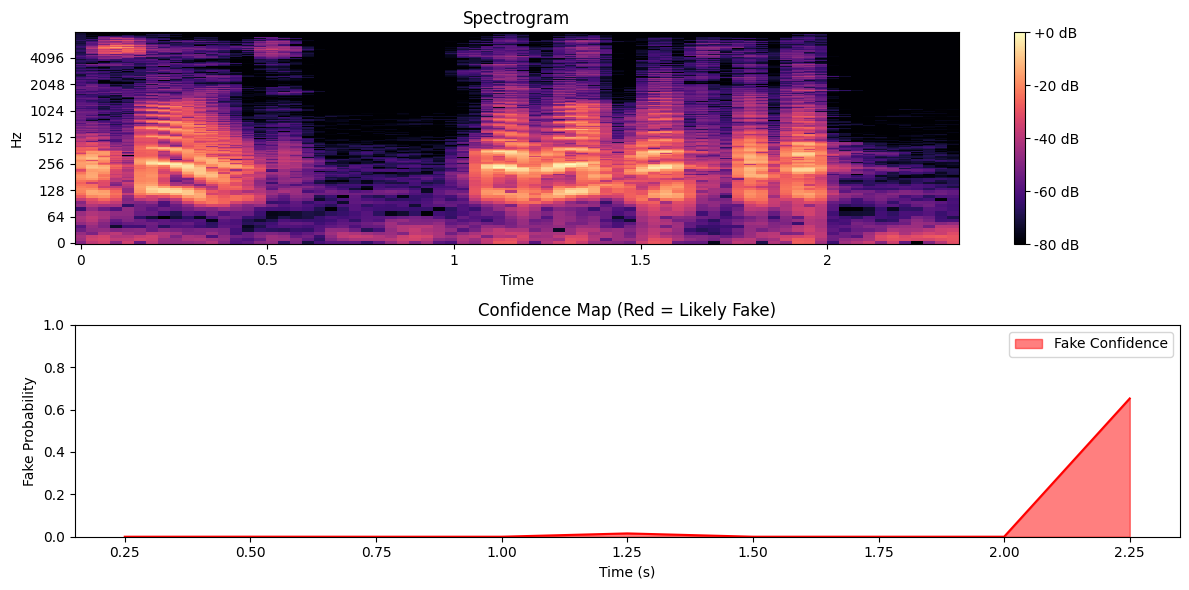

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Paths
model_path = "/content/drive/My Drive/Projects/audio_forensics_model.pth"
dataset_path = "/content/drive/My Drive/Projects/fake_or_real_dataset/"
fake_path = os.path.join(dataset_path, "fake")
real_path = os.path.join(dataset_path, "real")

# Load the trained model
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 6 * 50, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioCNN().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Parameters (same as feature extraction)
sample_rate = 16000
n_mfcc = 13
n_frames = 100
window_size = 0.5  # 0.5-second windows
hop_size = 0.25    # 0.25-second overlap

# Function to extract MFCCs for a segment
def extract_mfcc_segment(audio, sr, start, window_size, n_mfcc=n_mfcc, n_frames=n_frames):
    start_sample = int(start * sr)
    end_sample = start_sample + int(window_size * sr)
    if end_sample > len(audio):
        end_sample = len(audio)
        audio_segment = audio[start_sample:]
        if len(audio_segment) < int(window_size * sr):
            audio_segment = np.pad(audio_segment, (0, int(window_size * sr) - len(audio_segment)), mode='constant')
    else:
        audio_segment = audio[start_sample:end_sample]

    mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=n_mfcc)
    if mfccs.shape[1] > n_frames:
        mfccs = mfccs[:, :n_frames]
    else:
        pad_width = n_frames - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    return mfccs

# Pick a real audio file for testing
real_files = [f for f in os.listdir(real_path) if f.endswith('.wav')]
test_file = os.path.join(real_path, real_files[0])  # First real file
print(f"Generating confidence map for: {test_file}")

# Load audio
audio, sr = librosa.load(test_file, sr=sample_rate)
duration = librosa.get_duration(y=audio, sr=sr)

# Process audio in segments
starts = np.arange(0, duration - window_size + hop_size, hop_size)
confidence_scores = []

for start in starts:
    mfcc = extract_mfcc_segment(audio, sr, start, window_size)
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, 13, 100)
    with torch.no_grad():
        output = model(mfcc_tensor)
        probs = torch.softmax(output, dim=1)
        fake_prob = probs[0, 0].item()  # Probability of fake (class 0)
        confidence_scores.append(fake_prob)

# Plot spectrogram with confidence map
plt.figure(figsize=(12, 6))

# Spectrogram
plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")

# Confidence map
plt.subplot(2, 1, 2)
times = starts + window_size / 2  # Center of each window
plt.fill_between(times, confidence_scores, alpha=0.5, color='red', label='Fake Confidence')
plt.plot(times, confidence_scores, color='red')
plt.xlabel("Time (s)")
plt.ylabel("Fake Probability")
plt.title("Confidence Map (Red = Likely Fake)")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()